# Quantify transports across the Iceland-Faroe ridge by source and destination

- Lagrangian particle tracking in VIKING20X model

- Pilot test case for June 2016

- Particles tracked backwards for 2 years (for sources) and forward for 6 months (for destinations)

- Advection only

- Transport calculations based on the idea of particle track representing a streamtube with constant along-tube transport everywhere

The idea here is to use Lagrangian particle tracks to quantify model volume transports from the North Atlantic into the Arctic seas by source. This is partly motivated by an idea of Stuart's that 'all' the water heading north between Greenland-Iceland-Shetland goes through the Rockall Trough (with the northward transport west of the Rockall Bank circulating in the subpolar gyre).

I've started with the Iceland-Faroes Ridge (IFR) section. This is partly just because I have an 'emotional attachment' to the IFR having spent my first postdoc modelling it, and partly because I figured if Stuart is wrong, the transport across the IFR is likely where it will show up.

Obviously it is easier to quantify transports across sections from the model just by straight eulerian calculation, but even if this is done over the whole boundary of a closed volume it doesn't give you the pathways through the volume. A 3D streamfunction would be another possibility but that doesn't seem straightforward.

The basic idea is that each particle tracked represents a streamtube (I have no diffusion in the tracking). The volume transport along that streamtube is constant at any point along the length and determined by the transport where it crosses IFR. This we get by a simple calculation of cross-sectional area x velocity across the section.

Particles are positioned randomly in 2D along a section from Iceland to Faroes, then the same particles are tracked backwards for 2 years for sources and forwards for 6 months for destinations.

This is done using OceanParcels tracking software and Viking20x model fields on GEOMAR servers via python Jupyter notebooks. This notebook has the analysis of the tracks, the notebook running Parcels is separate. This is currently just testing the method, how many particles might be needed for robust results, most efficient initial particle distributions, etc.

The transport quantities are at the very end. 2000 particles across the section seems to give OK results but ideally might want more - s.d. in total transport across IFR of maybe 10-20% by selecting a different random 2000 particles. Also this is just a snapshot (though using monthly means). With a few (<10) different crossing times I've seen total transports between 2 and 7 Sv, so with 2000 particles sampling errors probably small compared to variability.

The results for 2016 shown here suggest that of the 6.5 Sv crossing IFR 0.6 Sv came through Rockall Trough, with most of the rest coming north west of Rockall Bank, and about 0.5 Sv where I haven't identified the source. My initial feeling from other years is that most of the variability is in the flow from W of Rockall Bank with always around 0.5 Sv through Rockall Trough.

I haven't looked at Faroe-Shetland Channel yet, so this is only part (and probably the smaller part) of the northward flow in NE Atlantic towards Arctic.

So, here we
- load lagrangian trajectory data that has been written by OceanParcels from particle tracking in Viking20x model (currently using monthly mean fields for speed)
    - particles tracked from a section across IFR
    - random release points along section
    - tracked forward for 6 months to id destinations
    - tracked backwards for 2 years to id sources
- plot sections
- plot trajectories
- subset trajectories based on source and destination
- estimate transports

Transports associated with different pathways are estimated by assuming that each particle crossing IFR has an associated volume transport, which it maintains throughout its life, given by the 
                velocity across the section * total cross-sectional area / number of particles
So like a streamtube...    

## To do

- calculate section area properly 
- explore sensitivity to particle numbers and random seed (i.e. do I have enough particles)
- calculate true transport across section in model
- not selecting ocean particles properly near bed - partial cells
- fix time units on track plots

## Technical preamble

In [1]:
%matplotlib inline

import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib.colors import ListedColormap
import cmocean as co

sns.set_palette("colorblind")

## Parameters

In [2]:
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/IcelandFaroe/') 
filename = 'Parcels_IFFForwards_1m_June2016_2000.nc'
filenameb = 'Parcels_IFFBackwards_1m_June2016_2000.nc'

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#velocity conversions on IFR (63.5N)

lat2metres = 60.0*1852.0
lon2metres = 60.0*1852.0*np.cos(np.radians(63.5))

sealandratio = 9308.0/20000.0
sectionAreaEW = 7.0 * 700.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
sectionAreaNS = 2.8 * 700.0 * sealandratio * lat2metres

nParticles = 2000.0

## Some helper and plotting functions

In [3]:
def plot_release():
    plt.figure(figsize = (12,5))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        20,
        ds.isel(obs=0).vvel.data.flatten()*lon2metres
         , vmin = -.2, vmax = .2
        ,cmap= co.cm.balance
    #    ,alpha=0.3
    )

    plt.ylim(700,0)

    plt.colorbar(label = "vvel [m/s]")
    plt.show()
    return


In [4]:
def plot_tracks(x,y,z,title):
    plt.figure(figsize = (12,9))

    # plot tracks as scatter plots

    plt.scatter(
        x
        ,y
        ,3
        ,z
        ,vmin = tvmin, vmax = tvmax
        ,cmap = co.cm.delta
    #    ,alpha=0.3
    )
    plt.colorbar(label = "time [stupid units. range 4 years, all cross IFR at 2 years]");

    # plot depth contours and land boundary from model bathymetry
    depth.isel(y=slice(1700, 2499), x=slice(1300, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500]
    );
    depth.isel(y=slice(1700, 2499), x=slice(1300, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'k', levels = [1]
    );
    # plt.savefig('upstream.png')
    plt.ylim(45,70)
    plt.xlim(-30,10)
    plt.title(title)
    plt.show()
    return

In [5]:
def plot_section_from_NW():
    plt.figure(figsize = (12,6))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        s = 20, color = 'k', label='from other, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).z.data.flatten(),
        s = 20, color = 'blue', label='from IFR, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).where(ds_area.isel(obs=-1).T_NorwSea).z.data.flatten(),
        s = 20, color = 'lightblue', label='from IFR, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).isel(obs=0).z.data.flatten(),
        s = 20, color = 'red', label='from W Iceland, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'pink', label='from W Iceland, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'green', label='from Greenland Sea, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'lightgreen', label='from Greenland Sea, went Norwegian Sea'
    )

    plt.legend(ncol=2)

    plt.ylim(1800,0)
    
    return

In [6]:
def plot_section_not_from_NW():
    plt.figure(figsize = (12,6))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        s = 20, color = 'k', label='from other, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).isel(obs=0).z.data.flatten(),
        s = 20, color = 'green', label='from WRB, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'lightgreen', label='from WRB, went North Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'cyan', label='from WRB, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).isel(obs=0).z.data.flatten(),
        s = 20, color = 'red', label='from RT, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'pink', label='from RT, went North Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'coral', label='from RT, went Norwegian Sea'
    )
    plt.legend(ncol=2)

    plt.ylim(1800,0)
    
    return

In [7]:
def apply_through_area(ds, min_lon, max_lon, min_lat, max_lat, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  (
                    (ds.lon > min_lon) * 
                    (ds.lon < max_lon) *
                    (ds.lat > min_lat) * 
                    (ds.lat < max_lat) *
                    (ds.time > min_time) *
                    (ds.time < max_time)
                    )
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [8]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  ((((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                     > 0.0) *
                    (ds.time > min_time) *
                    (ds.time < max_time))
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [9]:
def mask_tracks_by_source_sink(ds_full):
    # comes through Rockall Trough and W Scotland shelf
    ds_area = apply_through_area(ds_full,-13.5,-6.5,57.25,57.75,
                                 np.datetime64('2010-06-16'),np.datetime64('2016-06-16'),
                                 'F_RT_WSS')    
    # comes northward west of Rockall Bank
    ds_area = apply_through_area(ds_area,-60,-13.5,57.25,57.75,
                                 np.datetime64('2010-06-16'),np.datetime64('2016-06-16'),
                                 'F_WRB')  
    # comes clockwise round Iceland
    ds_area = apply_through_area(ds_area,-22,-20,65,70,np.datetime64('2010-06-16'),
                                 np.datetime64('2016-06-16'),
                                 'F_WIceland')  
    # comes from NW
    ds_area = apply_through_area(ds_area,-20,-6,68.5,70,
                                 np.datetime64('2010-06-16'),np.datetime64('2016-06-16'),
                                 'F_GreenSea')  
    # goes east
    ds_area = apply_left_of_line(ds_area,-17,-13,66,66,
                                 np.datetime64('2010-06-15'),np.datetime64('2016-06-15'),
                                 'F_West')
    # goes northeastward towards Arctic - all particles doing this pass north of Faroe
    ds_area = apply_through_area(ds_area,-6.5,-5.5,62.3,64.5,
                                 np.datetime64('2016-06-16'),np.datetime64('2020-06-16'),
                                 'T_NFaroes')    
    # goes west south of Iceland in SPG
    ds_area = apply_through_area(ds_area,-23,-22,62.,64.,
                                 np.datetime64('2016-06-16'),np.datetime64('2020-06-16'),
                                 'T_SIceland')  
    # goes to arctic
    ds_area = apply_left_of_line(ds_area,0,7,65,62,
                                 np.datetime64('2016-06-16'),np.datetime64('2020-06-16'),
                                 'T_NorwSea')
    # goes to north sea
    ds_area = apply_left_of_line(ds_area,5.1,-1.23,62.3,60.3,
                                 np.datetime64('2016-06-16'),np.datetime64('2020-06-16'),
                                 'T_NSea')
    return ds_area

In [10]:
def transports():
    NEwardsParticleTransport = (sectionAreaEW*dsb.isel(obs=0).vvel*lat2metres +
                            sectionAreaNS*dsb.isel(obs=0).uvel*lon2metres)/nParticles
    print('Total transport through F-S channel.....................',
          '{: .3f}'.format(NEwardsParticleTransport.sum().data/1.0e06),'  Sv')
    print('...from NW..............................................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes).sum().data/1.0e06),'  Sv')
    print('...excluding from NW....................................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).sum().data/1.0e06),'  Sv')
    print('.............of which............ from Rockall Trough...',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).sum().data/1.0e06),'  Sv')
    print('.............of which............ from West of Rockall..',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS == False).where(ds_area.isel(obs=-1).F_WRB).sum().data/1.0e06),'  Sv')
    return

## Load data

### Forward tracks then backward tracks

In [11]:
ds = xr.open_dataset(project_path / path_data_tracks / filename)
dsb = xr.open_dataset(project_path / path_data_tracks / filenameb)
ds_full = xr.concat([dsb,ds],dim='obs')

display(ds_full)

<xarray.Dataset>
Dimensions:     (obs: 917, traj: 1978)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 0.0 0.0 0.0 ... 3.999e+03 3.999e+03
    time        (traj, obs) datetime64[ns] 2016-06-15T12:00:00 ... 2016-12-17T12:00:00
    lat         (traj, obs) float64 63.05 63.06 63.08 63.09 ... 64.2 64.23 64.18
    lon         (traj, obs) float64 -9.125 -9.209 -9.278 ... 3.529 3.759 3.954
    z           (traj, obs) float64 378.9 375.5 364.3 ... 327.0 327.8 326.5
    temp        (traj, obs) float32 5.081556 5.0670276 ... 7.9025173 7.614768
    uvel        (traj, obs) float32 1.1118364e-06 8.774452e-07 ... 1.5990071e-06
    vvel        (traj, obs) float32 -6.140428e-08 ... -1.0886074e-06
    wvel        (traj, obs) float32 -2.6042544e-06 ... -6.5995824e-05
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.2
    parcels_mesh:           spherical

In [22]:
#ds_full = ds_full.rename({'temp':'temperature'})

display(ds_full)

ds_full.temperature.attrs['units'] = 'degree_C'

<xarray.Dataset>
Dimensions:      (obs: 917, traj: 1978)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory   (traj, obs) float64 0.0 0.0 0.0 ... 3.999e+03 3.999e+03
    time         (traj, obs) datetime64[ns] 2016-06-15T12:00:00 ... 2016-12-17T12:00:00
    lat          (traj, obs) float64 63.05 63.06 63.08 ... 64.2 64.23 64.18
    lon          (traj, obs) float64 -9.125 -9.209 -9.278 ... 3.529 3.759 3.954
    z            (traj, obs) float64 378.9 375.5 364.3 ... 327.0 327.8 326.5
    temperature  (traj, obs) float32 5.081556 5.0670276 ... 7.9025173 7.614768
    uvel         (traj, obs) float32 1.1118364e-06 ... 1.5990071e-06
    vvel         (traj, obs) float32 -6.140428e-08 ... -1.0886074e-06
    wvel         (traj, obs) float32 -2.6042544e-06 ... -6.5995824e-05
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.2
    parcels_mesh:           spherical

### Load model mesh mask

In [12]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

## Have a quick look

### Release positions of the particles on section from Faroes to Shetland

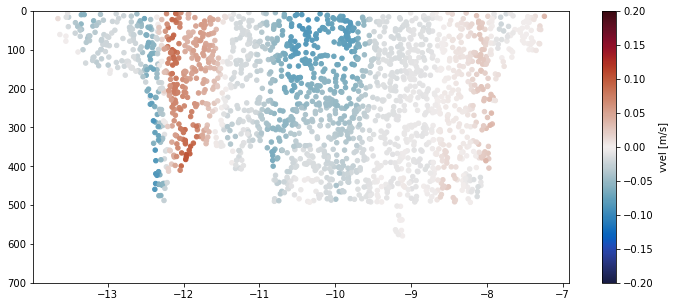

In [13]:
plot_release()

## Calculate some basic parameters from data for later

In [14]:
nParticles = ds.sizes['traj']

In [15]:
#centre time colourscale on release *DOESN'T WORK ON WINDOWS*
tvmin = dsb.time.min(skipna=True).data # oldest time
tvcentre = dsb.time.max(skipna=True).data # oldest time

tvmax = tvcentre + (tvcentre - tvmin)

### Plot trajectories

In [16]:
lon =    ds_full.where(ds_full.time > np.datetime64('2010-06-15')).lon.data.flatten()
lat =    ds_full.where(ds_full.time > np.datetime64('2010-06-15')).lat.data.flatten()
time =   ds_full.where(ds_full.time > np.datetime64('2010-06-15')).time.data.flatten()
 

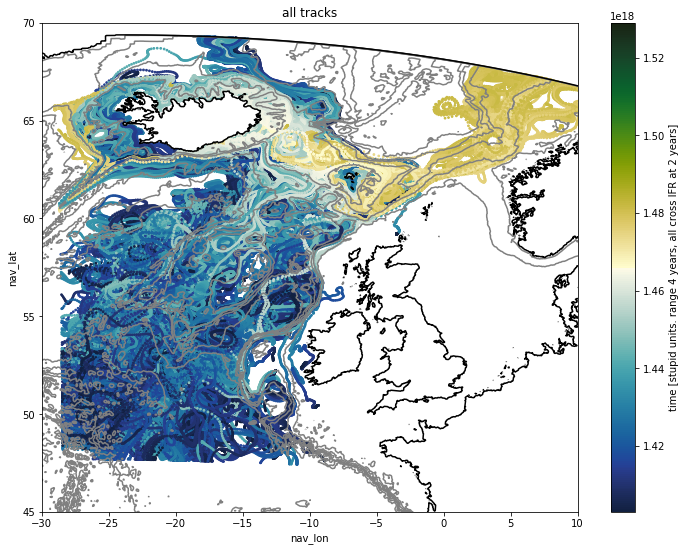

In [17]:
plot_tracks(lon,lat,time,'all tracks')

### Find subsets of trajectories passing through different areas, either upstream or downstream

This just tests whether particles were ever in an area, much easier than testing line crossings.

In [47]:
ds_area = mask_tracks_by_source_sink(ds_full)

## Plot tracks for some cases

### Tracks reaching FSC from NW

In [36]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_West == False).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_West == False).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_West == False).time.data.flatten()

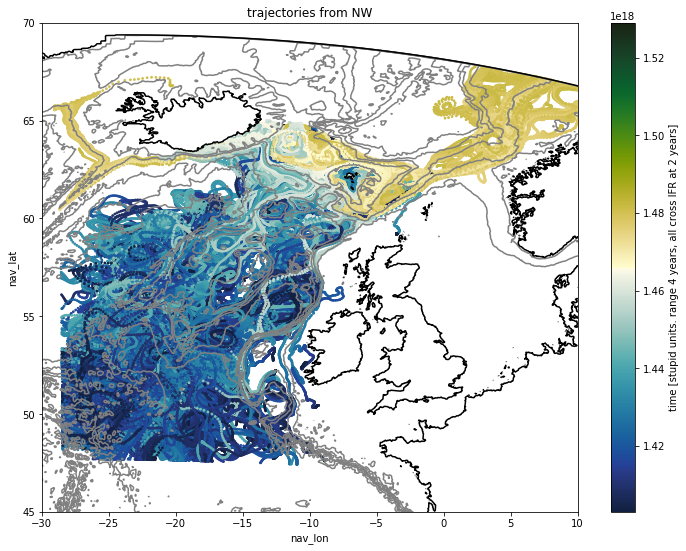

In [37]:
plot_tracks(lon,lat,time,'trajectories from NW')

In [42]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_West == False).where(ds_area.isel(obs=-1).T_NFaroes).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_West == False).where(ds_area.isel(obs=-1).T_NFaroes).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_West == False).where(ds_area.isel(obs=-1).T_NFaroes).time.data.flatten()

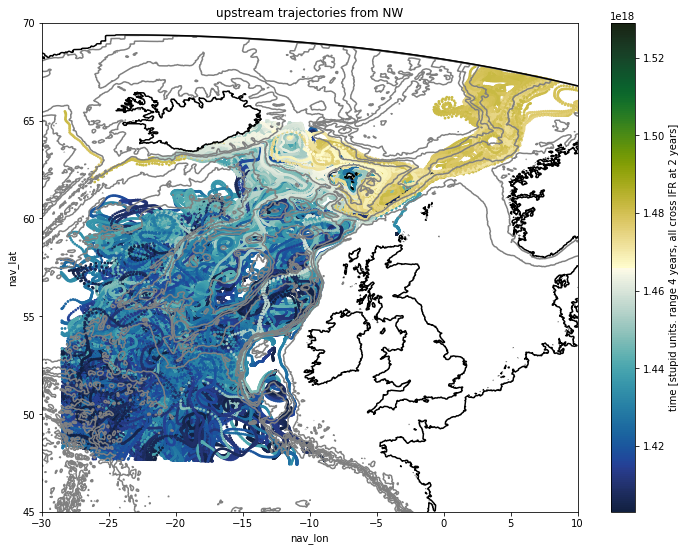

In [43]:
plot_tracks(lon,lat,time,'upstream trajectories from NW')

In [48]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_West == False).where(ds_area.isel(obs=-1).T_NFaroes).where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_West == False).where(ds_area.isel(obs=-1).T_NFaroes).where(ds_area.isel(obs=-1).T_NorwSea).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_West == False).where(ds_area.isel(obs=-1).T_NFaroes).where(ds_area.isel(obs=-1).T_NorwSea).time.data.flatten()

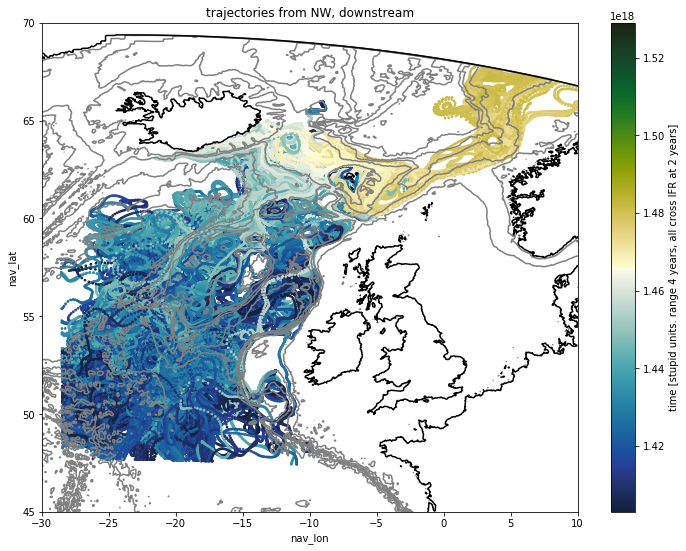

In [49]:
plot_tracks(lon,lat,time,'trajectories from NW, downstream')

### Tracks reaching FSC from south

In [25]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).time.data.flatten()

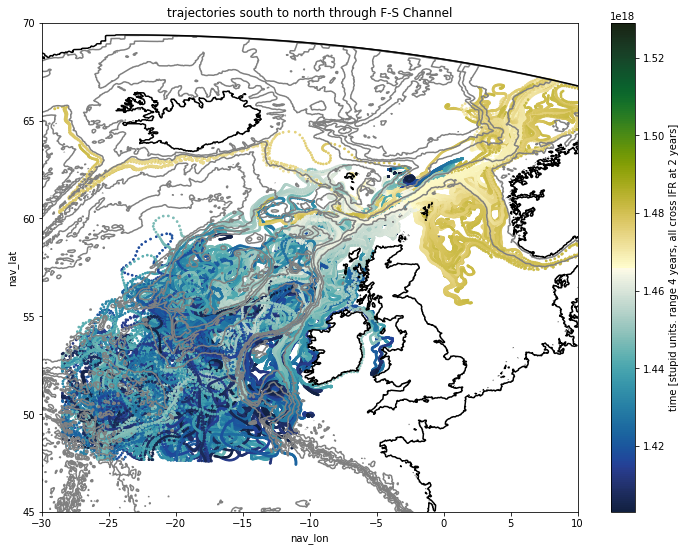

In [26]:
plot_tracks(lon,lat,time,'trajectories south to north through F-S Channel')

### Tracks reaching FSC from south through Rockall Trough

In [27]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).lat.data.flatten()
time =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).time.data.flatten()

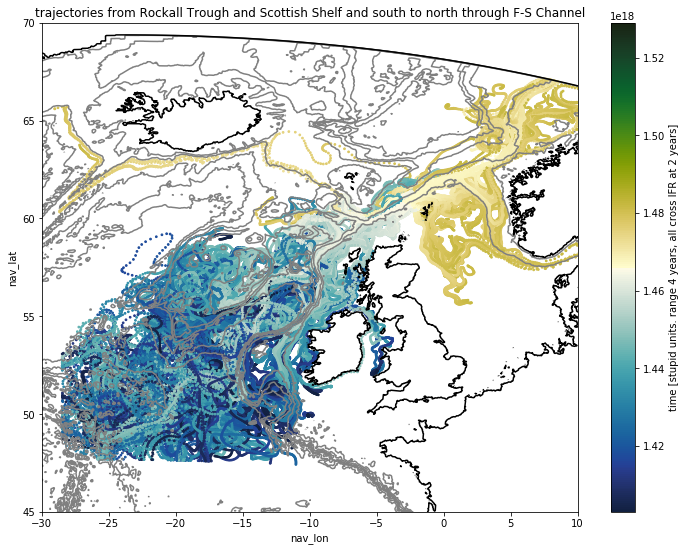

In [28]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and south to north through F-S Channel')

In [29]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NorwSea).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NorwSea).time.data.flatten())

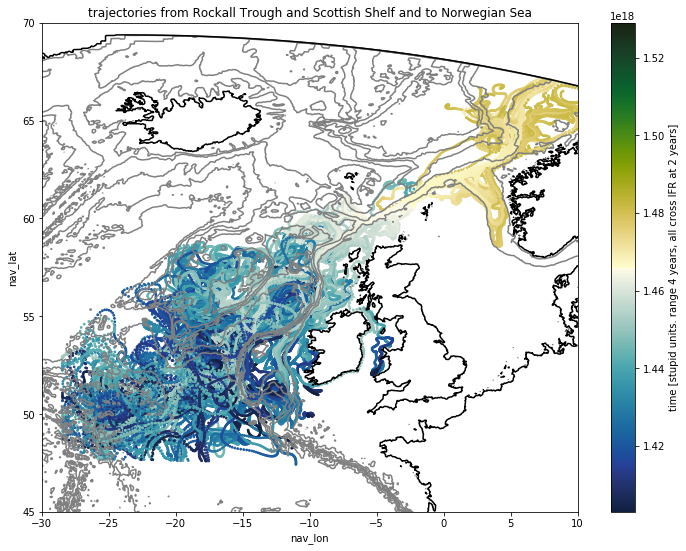

In [30]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and to Norwegian Sea')

In [31]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NSea)
                .where(ds_area.isel(obs=-1).T_NorwSea == False).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NSea)
                .where(ds_area.isel(obs=-1).T_NorwSea == False).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NSea)
                .where(ds_area.isel(obs=-1).T_NorwSea == False).time.data.flatten())

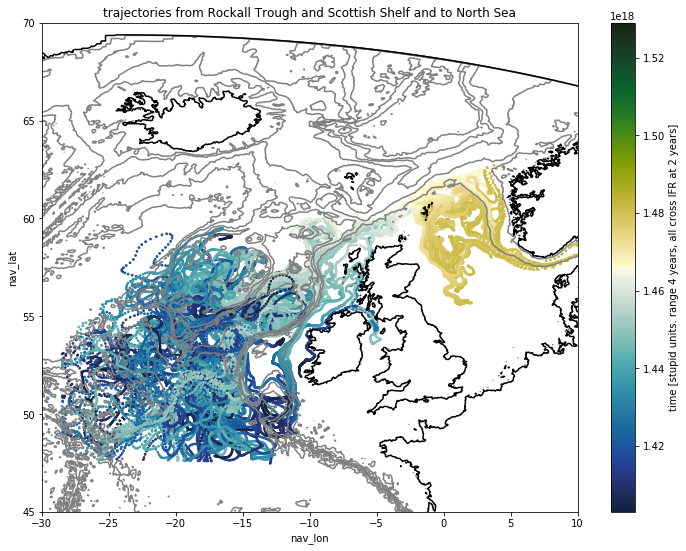

In [32]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and to North Sea')

### Tracks reaching FSC from south from west of Rockall

In [33]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).time.data.flatten())

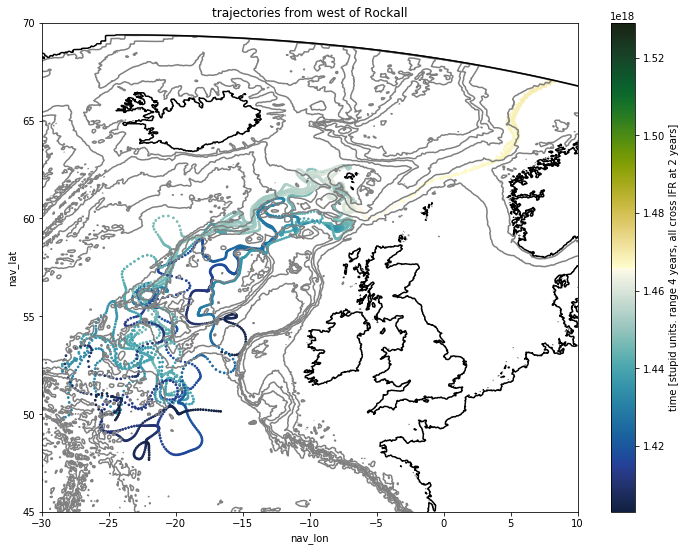

In [34]:
plot_tracks(lon,lat,time,'trajectories from west of Rockall')

### Others

In [35]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_SIceland).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_SIceland).lat.data.flatten()
time =    ds_area.where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_SIceland).time.data.flatten()


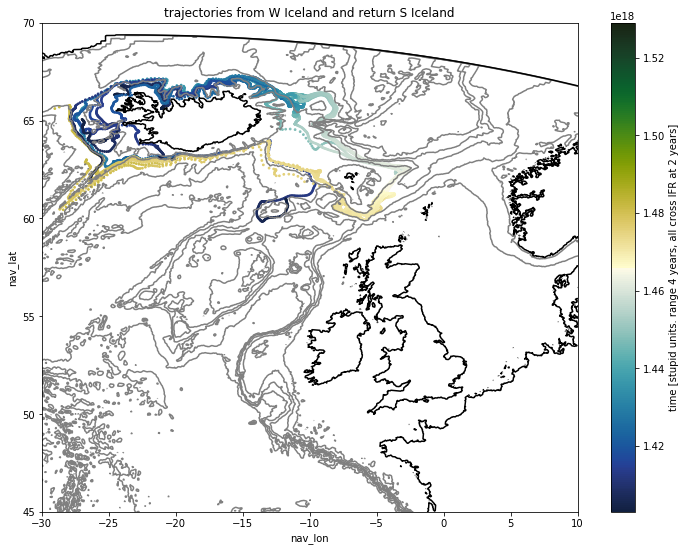

In [36]:
plot_tracks(lon,lat,time,'trajectories from W Iceland and return S Iceland')


In [37]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_GreenSea).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_GreenSea).lat.data.flatten()
time =    ds_area.where(ds_area.isel(obs=-1).F_GreenSea).time.data.flatten()


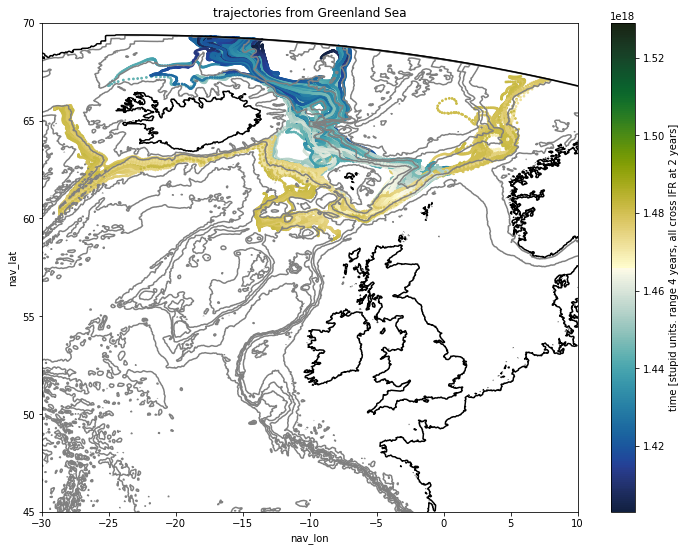

In [38]:
plot_tracks(lon,lat,time,'trajectories from Greenland Sea')


## Plot IFF section coloured by source

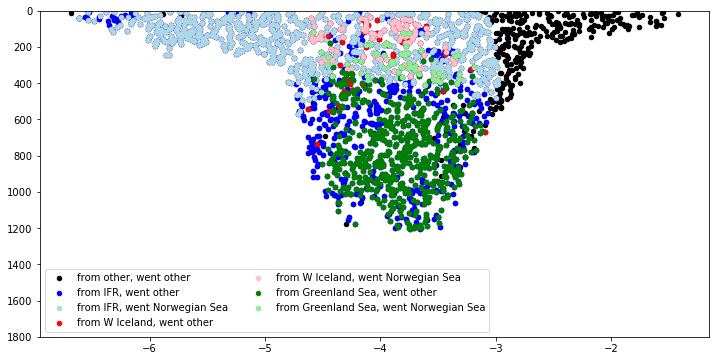

In [39]:
plot_section_from_NW()

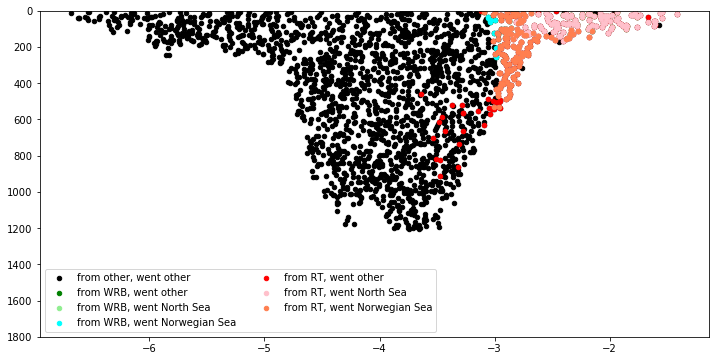

In [40]:
plot_section_not_from_NW()

## Estimate transports through FSC

In [41]:
transports()

Total transport through F-S channel.....................  1.464   Sv
...from NW.............................................. -1.909   Sv
...excluding from NW....................................  3.373   Sv
.............of which............ from Rockall Trough...  2.977   Sv
.............of which............ from West of Rockall..  0.340   Sv
